# 1. Veri Hazırlığı
 * Gerekli kütüphanelerin yüklenmesi
 * Veri yükleme
 * Eksik Değerlerin İşlenmesi
 * Veri Setini Eğitim ve Test Olarak Ayırma %80, %20
 * Özellik ölçekleme, daha hızlı ve stabil öğrenme

In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import cifar10

# CIFAR-10 veri setini yükle
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Veriyi düzleştir
x_train_flat = x_train.reshape(-1, 32 * 32 * 3)
x_test_flat = x_test.reshape(-1, 32 * 32 * 3)

# StandardScaler ile standartlaştırma
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train_flat)
x_test_scaled = scaler.transform(x_test_flat)

# Eğitim ve doğrulama veri setini ayır
x_train, x_val, y_train, y_val = train_test_split(x_train_scaled, y_train, test_size=0.2, random_state=42)

# Sınıf etiketlerini kategorik hale getir
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)

In [6]:
import numpy as np

# Eksik değer kontrolü
def check_missing_values(data, name="Veri"):
    missing = np.isnan(data).sum()  # NaN değerleri kontrol et
    infinite = np.isinf(data).sum()  # Sonsuz değerleri kontrol et
    if missing > 0 or infinite > 0:
        print(f"{name} setinde eksik (NaN) veya sonsuz (Inf) değerler var!")
        print(f"NaN sayısı: {missing}, Sonsuz sayısı: {infinite}")
    else:
        print(f"{name} setinde eksik veya sonsuz değer yok.")

# Eğitim, doğrulama ve test setlerini kontrol et
check_missing_values(x_train_scaled, "Eğitim")
check_missing_values(x_val, "Doğrulama")
check_missing_values(x_test_scaled, "Test")


Eğitim setinde eksik veya sonsuz değer yok.
Doğrulama setinde eksik veya sonsuz değer yok.
Test setinde eksik veya sonsuz değer yok.


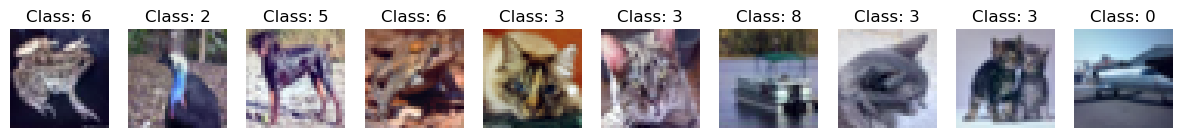

In [7]:
import matplotlib.pyplot as plt

# İlk 10 fotoğrafı göster
def show_sample_images(data, labels, num_samples=10):
    plt.figure(figsize=(15, 5))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i + 1)
        img = data[i].reshape(32, 32, 3)  # Görüntüyü yeniden şekillendir
        plt.imshow((img - img.min()) / (img.max() - img.min()))  # Görüntüyü normalize et
        plt.title(f"Class: {np.argmax(labels[i])}")
        plt.axis("off")
    plt.show()

# İlk 10 eğitim fotoğrafını göster
show_sample_images(x_train, y_train, num_samples=10)

# Model eğitimi ve Hiperparametre Optimizasyonu
* MLP modeli için GridSearch ile optimizasyon

In [8]:
# Veri boyutları kontrolü
print(x_train.shape) # yukarda scaler yaptım
print(y_train.shape)
print(x_test_scaled.shape)
print(y_test.shape)

(40000, 3072)
(40000, 10)
(10000, 3072)
(10000, 10)


In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import numpy as np


# MLP modelini tanımlayan fonksiyon
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam, SGD

def create_mlp_model(layer_sizes, learning_rate, activation, solver, alpha):
    model = Sequential()
    # İlk katman
    model.add(Dense(layer_sizes[0], input_dim=x_train.shape[1], activation=activation, kernel_regularizer='l2'))
    # Ek katmanlar
    for size in layer_sizes[1:]:
        model.add(Dense(size, activation=activation, kernel_regularizer='l2'))
    # Çıkış katmanı
    model.add(Dense(y_train.shape[1], activation='softmax'))
    
    # Optimizasyon algoritması
    if solver == 'adam':
        optimizer = Adam(learning_rate=learning_rate)
    elif solver == 'sgd':
        optimizer = SGD(learning_rate=learning_rate)
    
    # Model derleme
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Grid Search parametreleri
mlp_params = {
    'layer_sizes': [[64], [128], [128, 64], [256, 128]],  # Katman ve nöron kombinasyonları
    'learning_rate': [0.001, 0.01],
    'activation': ['relu', 'tanh'],  # Aktivasyon fonksiyonları
    'solver': ['adam', 'sgd'],       # Optimizasyon algoritmaları
    'alpha': [0.0001, 0.001]        # L2 regularization parametresi
}

best_accuracy = 0
best_params = None
best_mlp_model = None

# Tüm kombinasyonları dene
for layer_sizes in mlp_params['layer_sizes']:
    for learning_rate in mlp_params['learning_rate']:
        for activation in mlp_params['activation']:
            for solver in mlp_params['solver']:
                for alpha in mlp_params['alpha']:
                    # Modeli oluştur
                    model = create_mlp_model(layer_sizes, learning_rate, activation, solver, alpha)
                    
                    # Modeli eğit
                    history = model.fit(x_train, y_train, validation_data=(x_val, y_val),
                                        epochs=10, batch_size=64, verbose=0)
                    
                    # Doğrulama setinde tahmin yap
                    y_pred = np.argmax(model.predict(x_val), axis=1)
                    y_true = np.argmax(y_val, axis=1)

                    # Performans metriklerini hesapla
                    precision = precision_score(y_true, y_pred, average='macro')
                    recall = recall_score(y_true, y_pred, average='macro')
                    f1 = f1_score(y_true, y_pred, average='macro')
                    acc = accuracy_score(y_true, y_pred)

                    print(f"Params: {layer_sizes}, LR: {learning_rate}, Act: {activation}, Solver: {solver}, Alpha: {alpha} -> "
                          f"Acc: {acc:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")
                    
                    # En iyi modeli kontrol et ve güncelle
                    if acc > best_accuracy:
                        best_accuracy = acc
                        best_params = (layer_sizes, learning_rate, activation, solver, alpha)
                        best_mlp_model = model  # En iyi modeli sakla

print(f"MLP için en iyi parametreler: {best_params} -> Acc: {best_accuracy:.4f}")


C:\Users\besir\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Params: [64], LR: 0.001, Act: relu, Solver: adam, Alpha: 0.0001 -> Acc: 0.4416, Precision: 0.4439, Recall: 0.4420, F1: 0.4402


C:\Users\besir\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Params: [64], LR: 0.001, Act: relu, Solver: adam, Alpha: 0.001 -> Acc: 0.4420, Precision: 0.4377, Recall: 0.4424, F1: 0.4357


C:\Users\besir\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Params: [64], LR: 0.001, Act: relu, Solver: sgd, Alpha: 0.0001 -> Acc: 0.4363, Precision: 0.4327, Recall: 0.4363, F1: 0.4336


C:\Users\besir\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Params: [64], LR: 0.001, Act: relu, Solver: sgd, Alpha: 0.001 -> Acc: 0.4420, Precision: 0.4381, Recall: 0.4423, F1: 0.4389


C:\Users\besir\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Params: [64], LR: 0.001, Act: tanh, Solver: adam, Alpha: 0.0001 -> Acc: 0.3725, Precision: 0.3685, Recall: 0.3735, F1: 0.3640


C:\Users\besir\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Params: [64], LR: 0.001, Act: tanh, Solver: adam, Alpha: 0.001 -> Acc: 0.3766, Precision: 0.3755, Recall: 0.3769, F1: 0.3659


C:\Users\besir\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Params: [64], LR: 0.001, Act: tanh, Solver: sgd, Alpha: 0.0001 -> Acc: 0.4015, Precision: 0.3943, Recall: 0.4016, F1: 0.3950


C:\Users\besir\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Params: [64], LR: 0.001, Act: tanh, Solver: sgd, Alpha: 0.001 -> Acc: 0.4056, Precision: 0.3986, Recall: 0.4056, F1: 0.3980


C:\Users\besir\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Params: [64], LR: 0.01, Act: relu, Solver: adam, Alpha: 0.0001 -> Acc: 0.2599, Precision: 0.2569, Recall: 0.2627, F1: 0.2288


C:\Users\besir\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\besir\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Params: [64], LR: 0.01, Act: relu, Solver: adam, Alpha: 0.001 -> Acc: 0.2496, Precision: 0.2474, Recall: 0.2481, F1: 0.2211


C:\Users\besir\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\besir\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Params: [64], LR: 0.01, Act: relu, Solver: sgd, Alpha: 0.0001 -> Acc: 0.4883, Precision: 0.4845, Recall: 0.4886, F1: 0.4842


C:\Users\besir\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Params: [64], LR: 0.01, Act: relu, Solver: sgd, Alpha: 0.001 -> Acc: 0.4904, Precision: 0.4878, Recall: 0.4909, F1: 0.4866


C:\Users\besir\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Params: [64], LR: 0.01, Act: tanh, Solver: adam, Alpha: 0.0001 -> Acc: 0.2520, Precision: 0.2552, Recall: 0.2524, F1: 0.2463


C:\Users\besir\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Params: [64], LR: 0.01, Act: tanh, Solver: adam, Alpha: 0.001 -> Acc: 0.2563, Precision: 0.2480, Recall: 0.2566, F1: 0.2336


C:\Users\besir\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Params: [64], LR: 0.01, Act: tanh, Solver: sgd, Alpha: 0.0001 -> Acc: 0.4407, Precision: 0.4347, Recall: 0.4411, F1: 0.4365


C:\Users\besir\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Params: [64], LR: 0.01, Act: tanh, Solver: sgd, Alpha: 0.001 -> Acc: 0.4407, Precision: 0.4358, Recall: 0.4407, F1: 0.4357


C:\Users\besir\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Params: [128], LR: 0.001, Act: relu, Solver: adam, Alpha: 0.0001 -> Acc: 0.4247, Precision: 0.4283, Recall: 0.4253, F1: 0.4167


C:\Users\besir\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Params: [128], LR: 0.001, Act: relu, Solver: adam, Alpha: 0.001 -> Acc: 0.4266, Precision: 0.4349, Recall: 0.4292, F1: 0.4090


C:\Users\besir\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Params: [128], LR: 0.001, Act: relu, Solver: sgd, Alpha: 0.0001 -> Acc: 0.4484, Precision: 0.4435, Recall: 0.4481, F1: 0.4443


C:\Users\besir\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Params: [128], LR: 0.001, Act: relu, Solver: sgd, Alpha: 0.001 -> Acc: 0.4415, Precision: 0.4369, Recall: 0.4416, F1: 0.4379


C:\Users\besir\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Params: [128], LR: 0.001, Act: tanh, Solver: adam, Alpha: 0.0001 -> Acc: 0.3686, Precision: 0.3666, Recall: 0.3692, F1: 0.3602


C:\Users\besir\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Params: [128], LR: 0.001, Act: tanh, Solver: adam, Alpha: 0.001 -> Acc: 0.3677, Precision: 0.3685, Recall: 0.3686, F1: 0.3576


C:\Users\besir\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Params: [128], LR: 0.001, Act: tanh, Solver: sgd, Alpha: 0.0001 -> Acc: 0.4073, Precision: 0.4013, Recall: 0.4074, F1: 0.4015


C:\Users\besir\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Params: [128], LR: 0.001, Act: tanh, Solver: sgd, Alpha: 0.001 -> Acc: 0.4026, Precision: 0.3949, Recall: 0.4026, F1: 0.3957


C:\Users\besir\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Params: [128], LR: 0.01, Act: relu, Solver: adam, Alpha: 0.0001 -> Acc: 0.2605, Precision: 0.2896, Recall: 0.2624, F1: 0.2406


C:\Users\besir\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Params: [128], LR: 0.01, Act: relu, Solver: adam, Alpha: 0.001 -> Acc: 0.2721, Precision: 0.2716, Recall: 0.2730, F1: 0.2577


C:\Users\besir\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Params: [128], LR: 0.01, Act: relu, Solver: sgd, Alpha: 0.0001 -> Acc: 0.5070, Precision: 0.5076, Recall: 0.5076, F1: 0.5053


C:\Users\besir\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Params: [128], LR: 0.01, Act: relu, Solver: sgd, Alpha: 0.001 -> Acc: 0.5018, Precision: 0.5003, Recall: 0.5026, F1: 0.4970


C:\Users\besir\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Params: [128], LR: 0.01, Act: tanh, Solver: adam, Alpha: 0.0001 -> Acc: 0.2405, Precision: 0.2471, Recall: 0.2399, F1: 0.2074


C:\Users\besir\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Params: [128], LR: 0.01, Act: tanh, Solver: adam, Alpha: 0.001 -> Acc: 0.2352, Precision: 0.2341, Recall: 0.2339, F1: 0.2270


C:\Users\besir\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Params: [128], LR: 0.01, Act: tanh, Solver: sgd, Alpha: 0.0001 -> Acc: 0.4575, Precision: 0.4524, Recall: 0.4579, F1: 0.4529


C:\Users\besir\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Params: [128], LR: 0.01, Act: tanh, Solver: sgd, Alpha: 0.001 -> Acc: 0.4518, Precision: 0.4516, Recall: 0.4523, F1: 0.4502


C:\Users\besir\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Params: [128, 64], LR: 0.001, Act: relu, Solver: adam, Alpha: 0.0001 -> Acc: 0.4511, Precision: 0.4518, Recall: 0.4515, F1: 0.4471


C:\Users\besir\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Params: [128, 64], LR: 0.001, Act: relu, Solver: adam, Alpha: 0.001 -> Acc: 0.4422, Precision: 0.4526, Recall: 0.4425, F1: 0.4400


C:\Users\besir\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Params: [128, 64], LR: 0.001, Act: relu, Solver: sgd, Alpha: 0.0001 -> Acc: 0.4282, Precision: 0.4222, Recall: 0.4282, F1: 0.4236


C:\Users\besir\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Params: [128, 64], LR: 0.001, Act: relu, Solver: sgd, Alpha: 0.001 -> Acc: 0.4259, Precision: 0.4214, Recall: 0.4259, F1: 0.4215


C:\Users\besir\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Params: [128, 64], LR: 0.001, Act: tanh, Solver: adam, Alpha: 0.0001 -> Acc: 0.3689, Precision: 0.3693, Recall: 0.3687, F1: 0.3650


C:\Users\besir\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Params: [128, 64], LR: 0.001, Act: tanh, Solver: adam, Alpha: 0.001 -> Acc: 0.3793, Precision: 0.3718, Recall: 0.3804, F1: 0.3662


C:\Users\besir\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Params: [128, 64], LR: 0.001, Act: tanh, Solver: sgd, Alpha: 0.0001 -> Acc: 0.4027, Precision: 0.3955, Recall: 0.4027, F1: 0.3965


C:\Users\besir\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Params: [128, 64], LR: 0.001, Act: tanh, Solver: sgd, Alpha: 0.001 -> Acc: 0.3976, Precision: 0.3898, Recall: 0.3979, F1: 0.3906


C:\Users\besir\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Params: [128, 64], LR: 0.01, Act: relu, Solver: adam, Alpha: 0.0001 -> Acc: 0.2502, Precision: 0.2103, Recall: 0.2544, F1: 0.2040


C:\Users\besir\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\besir\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Params: [128, 64], LR: 0.01, Act: relu, Solver: adam, Alpha: 0.001 -> Acc: 0.2606, Precision: 0.2585, Recall: 0.2598, F1: 0.2272


C:\Users\besir\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Params: [128, 64], LR: 0.01, Act: relu, Solver: sgd, Alpha: 0.0001 -> Acc: 0.5132, Precision: 0.5083, Recall: 0.5140, F1: 0.5090


C:\Users\besir\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Params: [128, 64], LR: 0.01, Act: relu, Solver: sgd, Alpha: 0.001 -> Acc: 0.5095, Precision: 0.5080, Recall: 0.5089, F1: 0.5012


C:\Users\besir\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Params: [128, 64], LR: 0.01, Act: tanh, Solver: adam, Alpha: 0.0001 -> Acc: 0.2386, Precision: 0.2666, Recall: 0.2388, F1: 0.2250


C:\Users\besir\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Params: [128, 64], LR: 0.01, Act: tanh, Solver: adam, Alpha: 0.001 -> Acc: 0.2469, Precision: 0.2553, Recall: 0.2471, F1: 0.2369


C:\Users\besir\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Params: [128, 64], LR: 0.01, Act: tanh, Solver: sgd, Alpha: 0.0001 -> Acc: 0.4537, Precision: 0.4469, Recall: 0.4541, F1: 0.4469


C:\Users\besir\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Params: [128, 64], LR: 0.01, Act: tanh, Solver: sgd, Alpha: 0.001 -> Acc: 0.4538, Precision: 0.4482, Recall: 0.4543, F1: 0.4483


C:\Users\besir\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Params: [256, 128], LR: 0.001, Act: relu, Solver: adam, Alpha: 0.0001 -> Acc: 0.4381, Precision: 0.4314, Recall: 0.4390, F1: 0.4297


C:\Users\besir\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Params: [256, 128], LR: 0.001, Act: relu, Solver: adam, Alpha: 0.001 -> Acc: 0.4510, Precision: 0.4558, Recall: 0.4516, F1: 0.4453


C:\Users\besir\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Params: [256, 128], LR: 0.001, Act: relu, Solver: sgd, Alpha: 0.0001 -> Acc: 0.4409, Precision: 0.4376, Recall: 0.4410, F1: 0.4377


C:\Users\besir\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Params: [256, 128], LR: 0.001, Act: relu, Solver: sgd, Alpha: 0.001 -> Acc: 0.4342, Precision: 0.4295, Recall: 0.4343, F1: 0.4302


C:\Users\besir\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Params: [256, 128], LR: 0.001, Act: tanh, Solver: adam, Alpha: 0.0001 -> Acc: 0.3630, Precision: 0.3630, Recall: 0.3641, F1: 0.3563


C:\Users\besir\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Params: [256, 128], LR: 0.001, Act: tanh, Solver: adam, Alpha: 0.001 -> Acc: 0.3625, Precision: 0.3594, Recall: 0.3619, F1: 0.3548


C:\Users\besir\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Params: [256, 128], LR: 0.001, Act: tanh, Solver: sgd, Alpha: 0.0001 -> Acc: 0.4081, Precision: 0.4005, Recall: 0.4084, F1: 0.4013


C:\Users\besir\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Params: [256, 128], LR: 0.001, Act: tanh, Solver: sgd, Alpha: 0.001 -> Acc: 0.4115, Precision: 0.4048, Recall: 0.4117, F1: 0.4044


C:\Users\besir\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Params: [256, 128], LR: 0.01, Act: relu, Solver: adam, Alpha: 0.0001 -> Acc: 0.2821, Precision: 0.2966, Recall: 0.2832, F1: 0.2638


C:\Users\besir\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Params: [256, 128], LR: 0.01, Act: relu, Solver: adam, Alpha: 0.001 -> Acc: 0.2365, Precision: 0.2051, Recall: 0.2343, F1: 0.1985


C:\Users\besir\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\besir\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Params: [256, 128], LR: 0.01, Act: relu, Solver: sgd, Alpha: 0.0001 -> Acc: 0.5260, Precision: 0.5205, Recall: 0.5268, F1: 0.5199


C:\Users\besir\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Params: [256, 128], LR: 0.01, Act: relu, Solver: sgd, Alpha: 0.001 -> Acc: 0.5139, Precision: 0.5176, Recall: 0.5139, F1: 0.5135


C:\Users\besir\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Params: [256, 128], LR: 0.01, Act: tanh, Solver: adam, Alpha: 0.0001 -> Acc: 0.2230, Precision: 0.2174, Recall: 0.2223, F1: 0.1832


C:\Users\besir\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Params: [256, 128], LR: 0.01, Act: tanh, Solver: adam, Alpha: 0.001 -> Acc: 0.2480, Precision: 0.2601, Recall: 0.2466, F1: 0.2252


C:\Users\besir\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Params: [256, 128], LR: 0.01, Act: tanh, Solver: sgd, Alpha: 0.0001 -> Acc: 0.4597, Precision: 0.4554, Recall: 0.4599, F1: 0.4544


C:\Users\besir\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Params: [256, 128], LR: 0.01, Act: tanh, Solver: sgd, Alpha: 0.001 -> Acc: 0.4567, Precision: 0.4562, Recall: 0.4576, F1: 0.4528
MLP için en iyi parametreler: ([256, 128], 0.01, 'relu', 'sgd', 0.0001) -> Acc: 0.5260


- Modellerin En İyilerini Belirleme ve Confusion Matrix Görselleştirme

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
MLP Modeli - Sınıflandırma Raporu
              precision    recall  f1-score   support

           0       0.57      0.62      0.60      1000
           1       0.65      0.63      0.64      1000
           2       0.49      0.32      0.39      1000
           3       0.38      0.34      0.36      1000
           4       0.44      0.42      0.43      1000
           5       0.45      0.39      0.42      1000
           6       0.52      0.66      0.58      1000
           7       0.56      0.60      0.58      1000
           8       0.60      0.69      0.64      1000
           9       0.55      0.60      0.57      1000

    accuracy                           0.53     10000
   macro avg       0.52      0.53      0.52     10000
weighted avg       0.52      0.53      0.52     10000



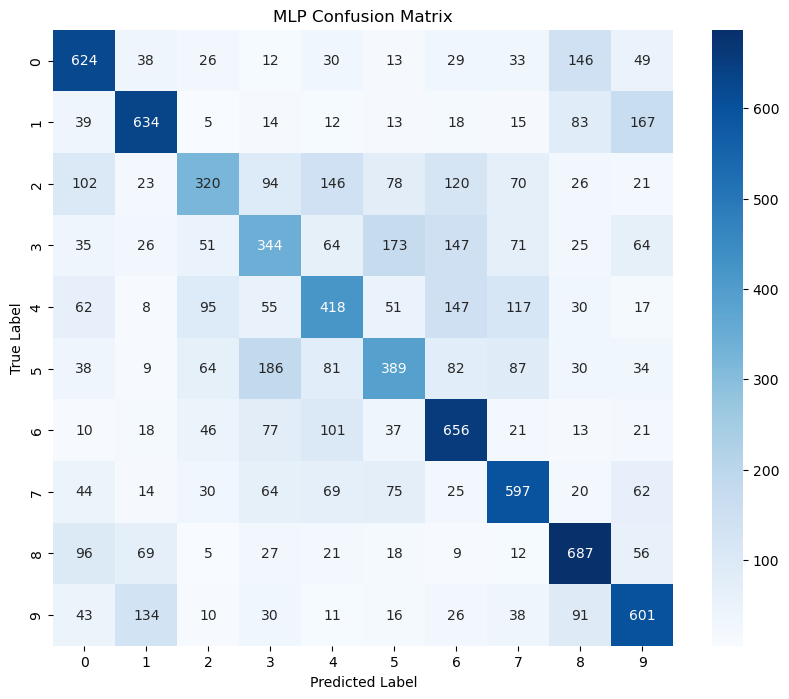

'\nplot_confusion_matrix(rbf_y_true, rbf_y_pred, title="RBF Confusion Matrix")\n'

In [12]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import seaborn as sns

# Confusion Matrix'i çizdirme fonksiyonu
def plot_confusion_matrix(y_true, y_pred, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    labels = range(10)  # CIFAR-10 sınıf sayısı
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title(title)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

# 1. MLP Modeli için en iyi sonucu elde eden modelin tahminlerini alın
# En iyi MLP modelinin tahminlerini al
mlp_y_pred = np.argmax(best_mlp_model.predict(x_test_scaled), axis=1)  # Test verisi üzerinden tahmin yapıyoruz
mlp_y_true = np.argmax(y_test, axis=1)
# 3. Confusion Matrix Görselleştirme
print("MLP Modeli - Sınıflandırma Raporu")
print(classification_report(mlp_y_true, mlp_y_pred))
# Görselleştirme
plot_confusion_matrix(mlp_y_true, mlp_y_pred, title="MLP Confusion Matrix")